# Transformers For Text Classification

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/Machine_Learning_Bootcamp/blob/main/Week 07 - Deep Learning for Sequence Modeling/2- Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Understanding The Transformer Architecture:

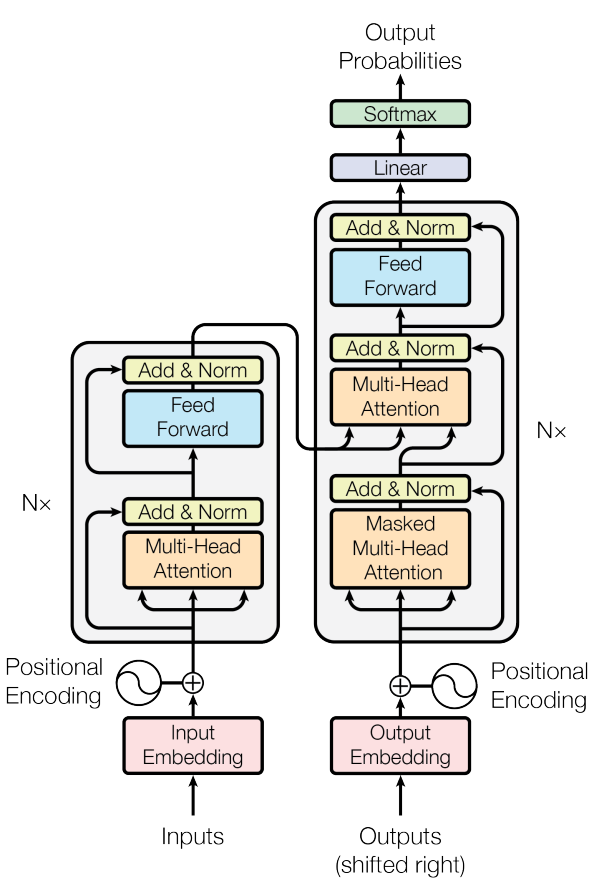

The transformers architecture published in the research paper titled "Attention Is All You Need" is one of the most influential papers in deep learning and natural language processing. The above image representation might seem quite complex to understand with a lot of elemental structures in the design. The code is, however, much simpler to parse. And by breaking down each component into individual entities, it becomes quite easy to understand all the core entities involved in the transformer design. 

Firstly, let us discuss about the left-hand side of the transformer architecture shown in the above figure. It consists of the encoder architecture with the positional encodings, inputs, input embeddings, and a block containing some neural network components. We will refer to this block as the transformer block, and it will be an integral aspect of understanding the working procedure of transformers.

The arrows represent the direct and skip connections that are to be made in the transformer architecture. The multi-head attention module will receive three inputs, namely values, keys and queries. The next three blocks are quite simple as we perform an addition and normalization operation, pass it through a feed-forward network, and reform the addition and normalization operation.

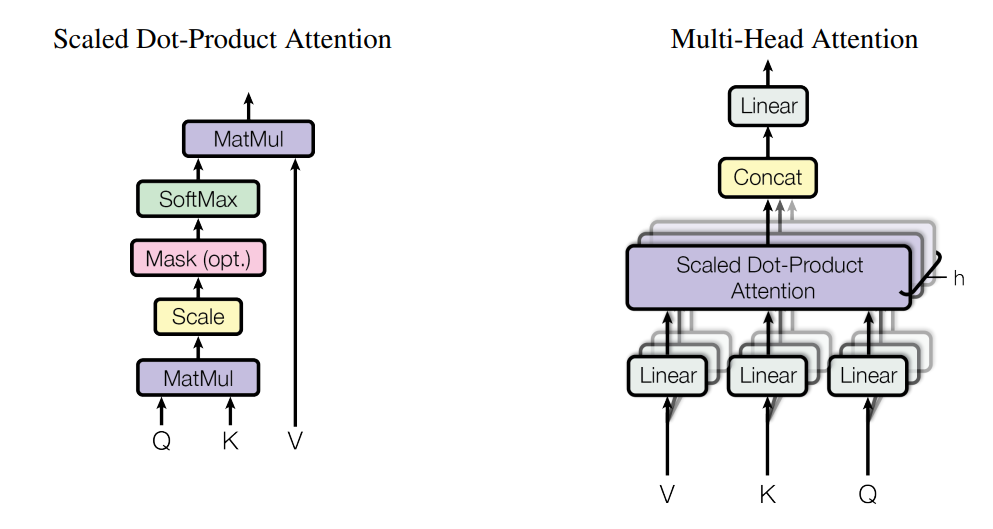

We will discuss the concept of multi-head attention in slightly more detail as the other components of the transformer network are quite straightforward to understand. The embedding input in the form of vectors, keys, and queries is passed through a linear layer. Let us say the embedding has a dimensionality of 64, and we are making use of four splits for each layer. Then, each of the layers passed through will have four blocks of 16-Dimensional data embedded in them.

This data is passed through the scaled dot-product attention, which utilizes a model similar to the one mentioned in the above figure. Also, the formula below represents the clear performance of the model, where the dot attention is equal to the product of the Softmax of the product of queries, Transpose of keys, divided by the scaling factor (which in this case is the square root of embedding size), and the vectors. Finally, the results are concatenated to retrieve the same size as the embedding, and then it is passed through a linear layer.

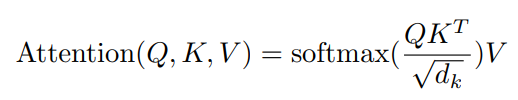


Finally, the right-hand side of the transformer network consists of the decoder architecture, which contains some similarities to the previously discussed encoder. They have a couple of transformer blocks, one with masked multi-head attention to ensure that each consecutive output only has knowledge of the previous input and not any other excessive information. The Nx in the figure represents the notion that there can be several stacks of encoder or decoder blocks to compute a particular task. For our project, we will utilize a simpler variation of the transformer block to accomplish the desired results for text classification.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection
import re

# We'll import the layers directly for easier model definition
import tensorflow as tf

In [ ]:
tf.random.set_seed(42)

In [ ]:
# Below are some parameters that we'll set up now, don't worry about it for now

vocab_size = 10000
embeddings_dims = 64 # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
max_sequence = 256

### Download Data From Kaggle

We'll be downloading the dataset from Kaggle, this requires using their download API, we'll go over the steps to do it.

First we'll be uploading `kaggle.json` into the '~\.kaggle` directory that we'll be creating, this will enable us to download datasets directly from Kaggle, more info on the process can be found here: https://github.com/Kaggle/kaggle-api 

In [ ]:
# First we'll create a new folder to put kaggle.json into
!mkdir /root/.kaggle

# Let's confirm that the directory is created
!cd /root/ && ls -la

mkdir: cannot create directory ‘/root/.kaggle’: File exists
total 60
drwx------ 1 root root 4096 Jul 14 13:48 .
drwxr-xr-x 1 root root 4096 Jul 14 13:46 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Jul 12 13:38 .cache
drwxr-xr-x 1 root root 4096 Jul 12 13:37 .config
drwxr-xr-x 5 root root 4096 Jul 12 13:36 .ipython
drwx------ 2 root root 4096 Jul 12 13:37 .jupyter
drwxr-xr-x 2 root root 4096 Jul 14 13:48 .kaggle
drwxr-xr-x 2 root root 4096 Jul 12 13:32 .keras
drwxr-xr-x 1 root root 4096 Jul 12 13:37 .local
drwxr-xr-x 4 root root 4096 Jul 12 13:37 .npm
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf


Now that `.kaggle` directory is all set up, we'll need to upload the `kaggle.json` file. For this you'll need a Kaggle account, you can obtain the file from this url `https://www.kaggle.com/<username>/account` (make sure to replace <username> with your actual username).

More info here: https://github.com/Kaggle/kaggle-api

In [ ]:
# Import colab's files module
from google.colab import files

# Start the upload, this will open the upload prompt below
uploaded = files.upload()

# Confirm that we've uploaded the kaggle.json file
print("Uploaded File:", list(uploaded.keys())[0])

Saving kaggle.json to kaggle.json
Uploaded File: kaggle.json


Now that we have the `kaggle.json` file uploaded, we'll need to move it to `.kaggle` directory. 

In [ ]:
# Move kaggle.json to .kaggle directory
!cp kaggle.json /root/.kaggle/kaggle.json

# Change file permission to allow python to access it
!chmod 600 /root/.kaggle/kaggle.json



And finally, we can download the dataset directly from kaggle using their Python API command (note that you may need to run `!pip install kaggle`)

If MNIST is the “hello world” of computer vision, then the IMDb reviews dataset is
the “hello world” of natural language processing: it consists of 50,000 movie reviews
in English (25,000 for training, 25,000 for testing) extracted from the famous Internet
Movie Database, along with a simple binary target for each review indicating whether
it is negative (0) or positive (1).

Now, let's unzip the downloaded file

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 19% 5.00M/25.7M [00:00<00:00, 47.9MB/s]
100% 25.7M/25.7M [00:00<00:00, 162MB/s] 


In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


### Load & Preprocess Data

First, we'll load the extracted csv file into a dataframe to examine the content.

In [ ]:
df = pd.read_csv("IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
# The text needs to be cleaned
df.review[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

#### Clean Text using RE 
A regular expression (or RE) specifies a set of strings that matches it; the functions in this module let you check if a particular string matches a given regular expression (or if a given regular expression matches a particular string, which comes down to the same thing).

In [ ]:
# Function to clean the text
def clean_text(text):
    """Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers."""
    text = text.lower()
    text = re.sub("-", " ", text)
    text = re.sub('"', " ", text)
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    text = " ".join(filter(lambda x: x[0] != "@", text.split()))
    return text


df["review"] = df.review.apply(clean_text)
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,petter mattei's love in the time of money is a...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative


In [ ]:
# Clean text
df.review[1]

"a wonderful little production. the filming technique is very unassuming very old time bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too! you can truly see the seamless editing guided by the references to williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master's of comedy and his life. the realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets (particularly of their flat with halliwell's murals decorating every surface) are terribly well done."

We can see that we have two columns, the review which has the review text that will be used as the input for the model, and sentiment, which is what the model will try to predict, let's split them into X's and y's  

In [ ]:
x = df.review
y = df.sentiment

x.shape, y.shape

((50000,), (50000,))

#### Tokenization

Since we know that neural network don't work with text, we'll need a way to prepare the review text to be consumed by the network.

Keras provides APIs for preparing text that can be fit and reused to prepare multiple text documents. This may be the preferred approach for large projects.

We'll first use the `Tokenizer` class from `tf.keras.preprocessing.text` module to convert tokens (i.e. words, symbols, numbers...etc.) into numbers that can be consumed by neural networks.

You can read the documentation of the `Tokenizer` class here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size,  # Maximum number of tokens to include, we'll use vocab_size that we defined earlier
    oov_token="<OOV>",  # A token that will replace words that will not be in the limited vocabulary set by vocab_size
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',  # Symbols that will be removed from the texts
)

# Now we will train the tokenizer on our datasets, this allows the tokenizer to learn the most frequent words and create an index for them

tokenizer.fit_on_texts(x)

Now we can use the tokenizer to convert texts into sequences of numbers (each token/word has its own unique index)

In [ ]:
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'a': 4,
 'of': 5,
 'to': 6,
 'is': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'be': 26,
 'one': 27,
 'he': 28,
 'all': 29,
 'at': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'so': 34,
 'who': 35,
 'from': 36,
 'like': 37,
 'or': 38,
 'just': 39,
 'her': 40,
 'out': 41,
 'about': 42,
 'if': 43,
 "it's": 44,
 'has': 45,
 'there': 46,
 'some': 47,
 'what': 48,
 'good': 49,
 'when': 50,
 'more': 51,
 'very': 52,
 'up': 53,
 'no': 54,
 'time': 55,
 'my': 56,
 'even': 57,
 'would': 58,
 'she': 59,
 'which': 60,
 'only': 61,
 'really': 62,
 'see': 63,
 'story': 64,
 'their': 65,
 'had': 66,
 'can': 67,
 'me': 68,
 'well': 69,
 'were': 70,
 'than': 71,
 'much': 72,
 'we': 73,
 'bad': 74,
 'been': 75,
 'get': 76,
 'do': 77,
 'great': 78,
 'other': 79,
 'will': 80,
 'also': 81,
 'into': 82,


In [ ]:
x_tokenized = tokenizer.texts_to_sequences(x)

# Let's print s string before and after tokenization and examine the differences
print(x[1])
print(x_tokenized[1])

a wonderful little production. the filming technique is very unassuming very old time bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too! you can truly see the seamless editing guided by the references to williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master's of comedy and his life. the realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets (particularly of their flat with halliwell's murals decorating every surface) are terribly well done.
[4, 390, 120, 349, 2, 1371, 2946, 7, 52, 

#### Padding Sequences

Let's look at the lengths of the different tokenized reviews



In [ ]:
print("Length of Review 1:", len(x_tokenized[0]))
print("Length of Review 10:", len(x_tokenized[9]))
print("Length of Review 1000:", len(x_tokenized[999]))

Length of Review 1: 307
Length of Review 10: 32
Length of Review 1000: 572


We can see that each tokenized review has different length. And since these tokenized reviews will be used as input to the model (which needs to be of a fixed shape), then clearly this won't work, an extra preprocessing step is required called `pad_sequences` available at `tf.keras.preprocessing.sequence`, this function will ensure that sequences are of same length by either clipping the sequence or padding it with zeros. 

In [ ]:
x_padded = tf.keras.preprocessing.sequence.pad_sequences(
    x_tokenized,  # The sequences that will be padded/clipped
    maxlen=max_sequence,  # The maximum length of the sequence using max_sequence that's defined earlier
    padding="post",  # Where we'll add zeros if sequence length is shorter that the maximum length, this will add zeros to the end of the sentence
)

# Let's print out the length of some padded sequences
print("Length of Review 1:", len(x_padded[0]))
print("Length of Review 10:", len(x_padded[9]))
print("Length of Review 1000:", len(x_padded[999]))

Length of Review 1: 256
Length of Review 10: 256
Length of Review 1000: 256


#### Preprocess Targets
Now that the inputs are all setup, let's work on the targets. Specifically, let's change posative/negative into 1/0.

In [ ]:
y.replace({"positive": 1, "negative": 0}, inplace=True)
y

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

### Train/Test Split
Now that everything is setup, all we need to do is creating our training/testing split using Scikit Learn's `model_selection.train_test_split`.

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_padded, y, test_size=0.05, random_state=42, stratify=y
)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((47500, 256), (47500,), (2500, 256), (2500,))

### Create TF Data Pipeline

In [ ]:
def dataset_creator(x, y):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.shuffle(50000)
    data = data.batch(32)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data


train_dataset = dataset_creator(x_train, y_train)
test_dataset = dataset_creator(x_test, y_test)

# Creating Transformer blocks and positional embedding:

We will now proceed to construct the transformer block, which follows a similar build as discussed in the previous section of the article. While I am going to utilize the multi-head attention layer that is available in the TensorFlow/Keras deep learning frameworks, you can modify the code and build your own custom multi-head layer to grant further control and access to the numerous parameters involved.

In the first function of the transformer block, we will initialize the required parameters, namely the attention layer, the batch normalization and dropout layers, and the feed-forward network. In the call function of the transformer block, we will define the layers accordingly, as discussed in the architecture overview section of the transformer block.

### Layer Normalization Layer.

Normalize the activations of the previous layer for each given example in a batch independently, rather than across a batch like Batch Normalization. i.e. applies a transformation that maintains the mean activation within each example close to 0 and the activation standard deviation close to 1.

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self,embeddings_dims,number_heads,linear_layer_dim):
        super(TransformerBlock,self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=number_heads,
                                                            key_dim=embeddings_dims,

        )
        self.layer_normalizing_1  = tf.keras.layers.LayerNormalization()
        self.ffn_1 = tf.keras.layers.Dense(units= linear_layer_dim, activation=tf.nn.relu)
        self.ffn_out = tf.keras.layers.Dense(units=embeddings_dims)
        self.layer_normalizing_2  = tf.keras.layers.LayerNormalization()

    def call(self,inputs):

        att = self.attention(inputs,inputs)
        out1 = self.layer_normalizing_1(inputs + att)

        ffn= self.ffn_1(out1)
        ffn = self.ffn_out(ffn)
        out2 = self.layer_normalizing_2(out1+ffn)

        return out2
        



In the next code block, we will define another function that will be useful for managing the positional embeddings that are specified in the research paper. We are creating two embedding layers, namely for the tokens and the token index positions. The below code block describes how to create a class with two functions. In the first function, we initialize the token and positional embeddings, and in the second function, we will call them and encode the respective embeddings accordingly.

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### What is positional encoding and Why do we need it in the first place?
Position and order of words are the essential parts of any language. They define the grammar and thus the actual semantics of a sentence. Recurrent Neural Networks (RNNs) inherently take the order of word into account; They parse a sentence word by word in a sequential manner. This will integrate the words’ order in the backbone of RNNs.

But the Transformer architecture ditched the recurrence mechanism in favor of multi-head self-attention mechanism. Avoiding the RNNs’ method of recurrence will result in massive speed-up in the training time. And theoretically, it can capture longer dependencies in a sentence.

As each word in a sentence simultaneously flows through the Transformer’s encoder/decoder stack, The model itself doesn’t have any sense of position/order for each word. Consequently, there’s still the need for a way to incorporate the order of the words into our model.

One possible solution to give the model some sense of order is to add a piece of information to each word about its position in the sentence. We call this “piece of information”, the positional encoding.

The first idea that might come to mind is to assign a number to each time-step within the [0, 1] range in which 0 means the first word and 1 is the last time-step. Could you figure out what kind of issues it would cause? One of the problems it will introduce is that you can’t figure out how many words are present within a specific range. In other words, time-step delta doesn’t have consistent meaning across different sentences.

Another idea is to assign a number to each time-step linearly. That is, the first word is given “1”, the second word is given “2”, and so on. The problem with this approach is that not only the values could get quite large, but also our model can face sentences longer than the ones in training. In addition, our model may not see any sample with one specific length which would hurt generalization of our model.

Ideally, the following criteria should be satisfied:

1. It should output a unique encoding for each time-step (word’s position in a sentence)
Distance between any two time-steps should be consistent across sentences with different lengths.
2. Our model should generalize to longer sentences without any efforts. Its values should be bounded.
3. It must be deterministic.

# Developing the model


There are several ways in which the developers can implement the transformer model for the text classification task. It is usually common practice to use a separate encoder and decoder class to perform these actions separately. In this section, we will leverage a fairly simple method to develop our model, and utilize it accordingly for the task of text classification. We will declare our embedding dimensions for each token, the number of attention heads to use, and the size of the layers of the feed-forward network in the transformer. Then, with the help of the utility that we created by the previous transformer blocks and the positional embedding class, we will develop the model.

It is notable that we are using both the Sequential and Functional API models, allowing us to have more significant control over the model architecture. We will give an input containing the vectors of the sentence, for which we create an embedding and pass it through a transformer block. Finally, we have a global average pooling layer, a dropout, and a dense layer to return the probabilities of the possibilities of the sentence. We can use the Argmax function in numpy to obtain the correct result. Below is the code block to develop the model.

In [ ]:


class TransformerModel(tf.keras.Model):
    def __init__(self,embed_dim,maxlen,vocab_size):
        super(TransformerModel,self).__init__()
        self.embedding = TokenAndPositionEmbedding(maxlen,vocab_size=vocab_size,embed_dim=embed_dim)

        self.transformer_block_1 = TransformerBlock(embeddings_dims=embed_dim,
                                                    number_heads=4,
                                                    linear_layer_dim=32) 
        self.transformer_block_2 = TransformerBlock(embeddings_dims=embed_dim,
                                                    number_heads=8,
                                                    linear_layer_dim=64)
        
        self.D1 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)
        self.D1_dropout = tf.keras.layers.Dropout(rate=0.3)
        self.out = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)


    def call(self,x):

        x= self.embedding(x)
        x = self.transformer_block_1(x)
        x = self.transformer_block_2(x )
        x =tf.keras.layers.GlobalAvgPool1D()(x)
        x = self.D1(x)
        x = self.D1_dropout(x)
        x = self.out(x)

        return x 




In [ ]:
model = TransformerModel(embed_dim=embeddings_dims,
                         maxlen=max_sequence,
                         vocab_size=vocab_size)

In [ ]:
for x,y in train_dataset.take(1):
    pred = model(x)

pred

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.4987678 ],
       [0.5657038 ],
       [0.5635596 ],
       [0.5153603 ],
       [0.5756152 ],
       [0.5251847 ],
       [0.604415  ],
       [0.53033715],
       [0.5190372 ],
       [0.5965033 ],
       [0.61358404],
       [0.5273373 ],
       [0.5772303 ],
       [0.5570751 ],
       [0.5113476 ],
       [0.51563567],
       [0.5661314 ],
       [0.5658809 ],
       [0.5311335 ],
       [0.5210122 ],
       [0.5186073 ],
       [0.5841144 ],
       [0.5382936 ],
       [0.5745707 ],
       [0.5561483 ],
       [0.59898454],
       [0.60191864],
       [0.574772  ],
       [0.5186073 ],
       [0.52852666],
       [0.54263   ],
       [0.6079387 ]], dtype=float32)>

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(train_dataset, epochs=1, validation_data=test_dataset)

1485/1485 [==============================] - 48s 31ms/step - loss: 0.3371 - accuracy: 0.8461 - val_loss: 0.2552 - val_accuracy: 0.8932
